# 📘 Next-Generation Spam Filtering - CNN 中文分類模型
使用 `jieba` 分詞與 TF-IDF 特徵向量，搭配 CNN 進行七類分類。

## 📦 第 1 部分：匯入必要套件

In [1]:

import pandas as pd
import re
import jieba
import numpy as np
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## 📑 第 2 部分：讀取與預處理資料

In [2]:

df = pd.read_csv("test.csv")
df["text"] = df["subject"].fillna('') + " " + df["message"].fillna('')

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9\s]', '', text)
    return text.lower().strip()

df["text_clean"] = df["text"].apply(clean_text)
df[["text", "text_clean"]].head()


,text,text_clean
0,The FuelCell Rebel 全新顏色\n\nNew Balance\nhttps:...,the fuelcell rebel 全新顏色\n\nnew balance\n\n\n\n...
1,1111人力銀行推薦 -【桃園台茂店【涮乃葉】兼職人員及大專院校實習】 \n \n ...,1111人力銀行推薦 桃園台茂店涮乃葉兼職人員及大專院校實習 \n \n 轉寄履...
2,陳任璿-2025/03/16 履歷職缺配對通知 \n 職缺配對 ...,陳任璿20250316 履歷職缺配對通知 \n 職缺配對 ...
3,你的 Apple 開立發票通知 \n \n開立發票通知\n\n\n A...,你的 apple 開立發票通知 \n \n開立發票通知\n\n\n a...
4,大谷翔平，準備好續集 The Ohtani Signature Collection\n\n...,大谷翔平準備好續集 the ohtani signature collection\n\nn...


## 📊 第 3 部分：類別統計與可視化

C:\Users\user\AppData\Local\Temp\ipykernel_40176\824136342.py:9: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_40176\824136342.py:9: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_40176\824136342.py:9: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_40176\824136342.py:9: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24067 (

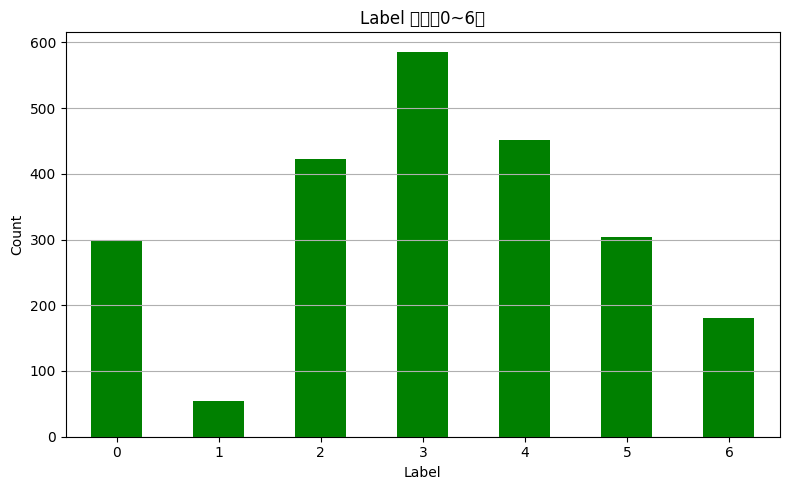

In [3]:

label_counts = df["label"].value_counts().sort_index()
plt.figure(figsize=(8,5))
label_counts.plot(kind="bar", color="green")
plt.title("Label 分布（0~6）")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis="y")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## ✂️ 第 4 部分：分詞、特徵抽取與資料分割

In [4]:

# 分詞
def tokenize(text):
    return " ".join(jieba.cut(text))

df["tokens"] = df["text_clean"].apply(tokenize)

# 標籤編碼
label_encoder = LabelEncoder()
df["encoded_label"] = label_encoder.fit_transform(df["label"])

# 切割資料集
X_train, X_test, y_train, y_test = train_test_split(
    df["tokens"], df["encoded_label"], test_size=0.2, random_state=42, stratify=df["encoded_label"]
)

# 顯示類別統計
def print_counter(title, counter_dict):
    print(f"{title} 各類別數量：")
    for k in sorted(counter_dict):
        print(f"類別 {k}：{counter_dict[k]} 筆")
    print()

print_counter("全體資料集", Counter(df["label"]))
print_counter("訓練集", Counter(y_train))
print_counter("驗證集", Counter(y_test))


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model cost 0.285 seconds.
Prefix dict has been built successfully.


全體資料集 各類別數量：
類別 0：300 筆
類別 1：55 筆
類別 2：422 筆
類別 3：586 筆
類別 4：452 筆
類別 5：304 筆
類別 6：181 筆

訓練集 各類別數量：
類別 0：240 筆
類別 1：44 筆
類別 2：338 筆
類別 3：469 筆
類別 4：361 筆
類別 5：243 筆
類別 6：145 筆

驗證集 各類別數量：
類別 0：60 筆
類別 1：11 筆
類別 2：84 筆
類別 3：117 筆
類別 4：91 筆
類別 5：61 筆
類別 6：36 筆



## 🔍 第 5 部分：TF-IDF 特徵抽取

In [5]:

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

print("TF-IDF 特徵維度：", X_train_tfidf.shape[1])


TF-IDF 特徵維度： 5000


## 🧠 第 6 部分：建立 CNN 模型

In [6]:

model = tf.keras.Sequential([
    tf.keras.layers.Reshape((X_train_tfidf.shape[1], 1), input_shape=(X_train_tfidf.shape[1],)),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 5000, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 4996, 128)         768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2498, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2496, 64)          24640     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4

## 🔁 第 7 部分：模型訓練

In [7]:

history = model.fit(X_train_tfidf, y_train, validation_data=(X_test_tfidf, y_test), epochs=10, batch_size=32)


Epoch 1/10
58/58 [==============================] - 20s 220ms/step - loss: 1.8703 - accuracy: 0.2255 - val_loss: 1.8017 - val_accuracy: 0.2935
Epoch 2/10
58/58 [==============================] - 8s 135ms/step - loss: 1.8086 - accuracy: 0.2957 - val_loss: 1.7561 - val_accuracy: 0.4457
Epoch 3/10
58/58 [==============================] - 3s 50ms/step - loss: 1.7400 - accuracy: 0.3582 - val_loss: 1.6442 - val_accuracy: 0.4043
Epoch 4/10
58/58 [==============================] - 7s 115ms/step - loss: 1.6334 - accuracy: 0.4000 - val_loss: 1.5545 - val_accuracy: 0.4674
Epoch 5/10
58/58 [==============================] - 7s 112ms/step - loss: 1.5924 - accuracy: 0.4103 - val_loss: 1.4905 - val_accuracy: 0.4826
Epoch 6/10
58/58 [==============================] - 4s 69ms/step - loss: 1.5487 - accuracy: 0.4272 - val_loss: 1.4778 - val_accuracy: 0.4457
Epoch 7/10
58/58 [==============================] - 4s 75ms/step - loss: 1.5387 - accuracy: 0.4359 - val_loss: 1.4946 - val_accuracy: 0.4283
Epoch 8/

## 📈 第 8 部分：訓練過程視覺化

d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36942 (\N{CJK UNIFIED IDEOGRAPH-904E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31243 (\N{CJK UNIFIED IDEOGRAPH-7A0B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  

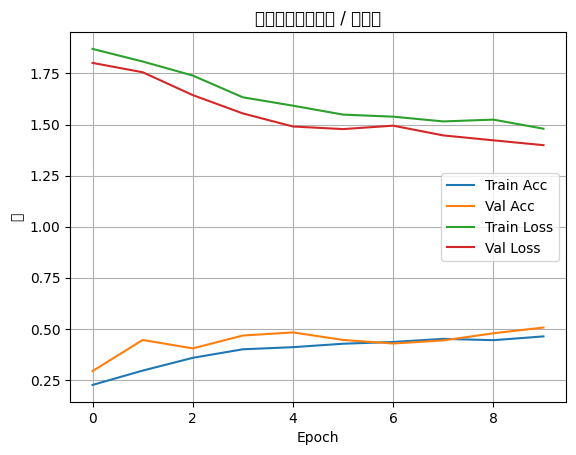

In [8]:

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("訓練過程（準確率 / 損失）")
plt.xlabel("Epoch")
plt.ylabel("值")
plt.legend()
plt.grid(True)
plt.show()


## 📊 第 9 部分：模型評估與混淆矩陣

15/15 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        60
           1     0.0000    0.0000    0.0000        11
           2     0.4632    0.7500    0.5727        84
           3     0.6543    0.9060    0.7599       117
           4     0.4412    0.6593    0.5286        91
           5     0.1538    0.0656    0.0920        61
           6     0.0000    0.0000    0.0000        36

    accuracy                         0.5065       460
   macro avg     0.2447    0.3401    0.2790       460
weighted avg     0.3587    0.5065    0.4146       460



d:\文大專題\program\Lingspam\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\文大專題\program\Lingspam\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\文大專題\program\Lingspam\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\文大專題\program\Lingspam\.venv\lib\si

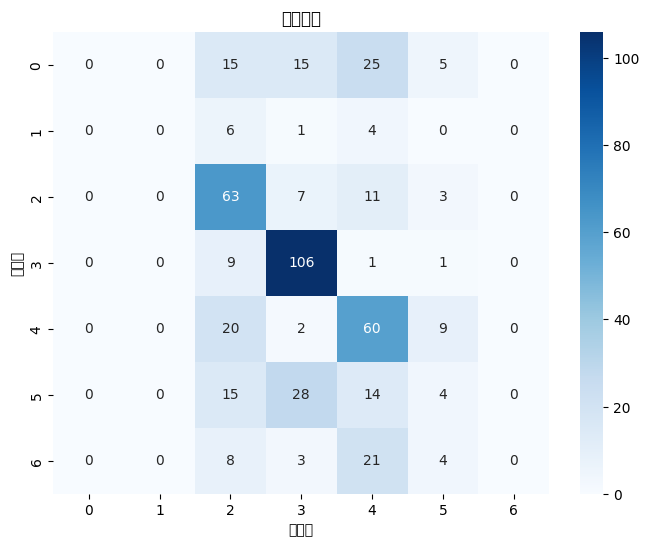

In [9]:

y_pred = model.predict(X_test_tfidf)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_labels, digits=4))

cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("混淆矩陣")
plt.xlabel("預測值")
plt.ylabel("實際值")
plt.show()
